In [2]:
import os
import re
from collections import defaultdict

In [3]:
log_filename = "SIR_Hoya.log"
dim = 50,50
patt_out_line = ".*Y / (?P<time>[0-9]{2}:[0-9]{2}:[0-9]{2}:[0-9]{3})(?::0)? / [a-zA-Z0-9]+\((?P<x>[0-9]+),(?P<y>[0-9]+)\)\([0-9]+\) / out_(?P<state>infec|rec|sus) / +(?P<perc>[0-9.-]+) (?:/|para) [a-zA-Z0-9]+\([0-9]+\)"

In [4]:
COLOR_SUSCEPTIBLE = "#3498db"
COLOR_INFECTED = "#e74c3c"
COLOR_RECOVERED = "#2ecc71"

In [5]:
def time_str_to_ts(time_str):
  patt_time = "([0-9]{2}):([0-9]{2}):([0-9]{2}):([0-9]{3})"
  match = re.match(patt_time, time_str)
  if not match:
    raise RuntimeError("Error converting simulation time")
  tu = list(map(int, match.groups()))
  return tu[3] + tu[2]*1000 + tu[1]*60000 + tu[0]*3600000

def curr_states_to_df_row(sim_time, curr_states):
    sus_acc = 0
    inf_acc = 0
    rec_acc = 0
    for i in range(len(curr_states)):
        for j in range(len(curr_states[0])):
            sus, inf, rec = curr_states[i][j]
            sus_acc += sus
            inf_acc += inf
            rec_acc += rec
            
    num_cells = len(curr_states) * len(curr_states[0])
    sus_acc /= num_cells
    inf_acc /= num_cells
    rec_acc /= num_cells
    
    #print(curr_time, sus_acc + inf_acc + rec_acc)
    assert 0.999 <= sus_acc + inf_acc + rec_acc < 1.001
    
    return [time_str_to_ts(sim_time)-1, sus_acc, inf_acc, rec_acc]

In [6]:
curr_time = None
curr_states = []

for _ in range(dim[0]):
    curr_states.append([])
    for _ in range(dim[1]):
        curr_states[-1].append([100, 0, 0])

In [7]:
states = ["sus", "infec", "rec"]
data = []

with open(log_filename, "r") as log_file:
  for line in log_file:
    line = line.strip()
    match = re.match(patt_out_line, line)
    if not match:
      continue
    if curr_time is None:
      curr_time = match.group("time")
    elif curr_time != match.group("time"):
      #print("Changed to " + match.group("time"))

      #row = [time_str_to_ts(curr_time)] + dict_to_states_row(dict(state_count.items()))
      if curr_time != "00:00:00:000":
          data.append(curr_states_to_df_row(curr_time, curr_states))
      #print("Changing from %s to %s" % (curr_time, match.group("time")))
      
      curr_time = match.group("time")

    x = int(match.group("x"))
    y = int(match.group("y"))
    
    perc = float(match.group("perc"))
    curr_states[x][y][states.index(match.group("state"))] = perc 
    
  data.append(curr_states_to_df_row(curr_time, curr_states))


### Visualization

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [9]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [10]:
columns = ["time", "susceptible", "infected", "recovered"]
df_vis = pd.DataFrame(data, columns=columns)
df_vis = df_vis.set_index("time")
df_vis.to_csv("states.csv")
df_vis.head(100)

,susceptible,infected,recovered
time,,,
0,0.999720,0.000280,0.000000
1,0.999640,0.000248,0.000112
2,0.999556,0.000248,0.000196
3,0.999476,0.000240,0.000284
4,0.999348,0.000288,0.000364
...,...,...,...
75,0.053448,0.000376,0.946176
76,0.053544,0.000184,0.946272
77,0.053628,0.000060,0.946312


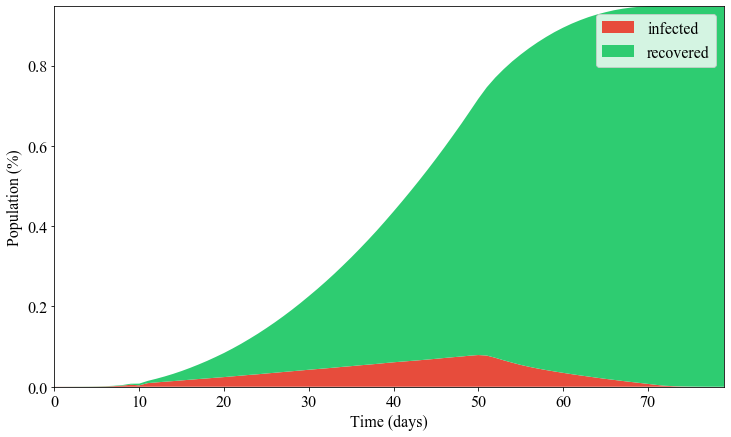

In [11]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["infected", "recovered"]
colors=[COLOR_INFECTED, COLOR_RECOVERED]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_area.pdf")

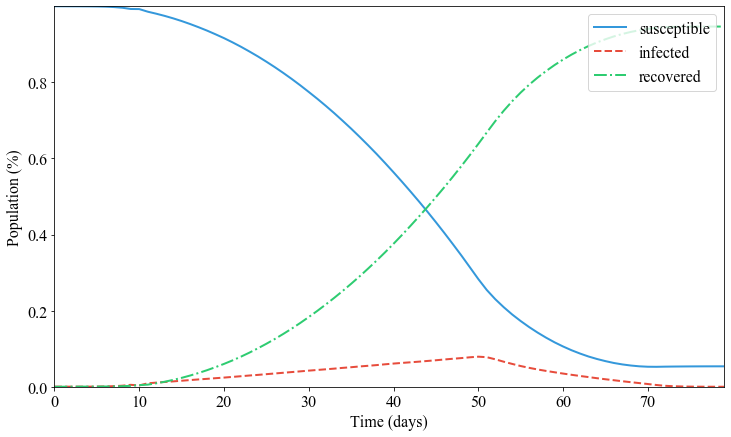

In [12]:
fig, ax = plt.subplots(figsize=(12,7))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["infected"], label="infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["recovered"], label="recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_lines.pdf")